# Importing Libraries!

In [1]:
# Importing Modules:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display, Markdown
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from time import perf_counter
import seaborn as sns

def printmd(string):
    # Print with Markdowns:  
    display(Markdown(string))

In [2]:
image_dir = Path('../input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images')

# Get filepaths and labels:
filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

In [3]:
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels:
image_df = pd.concat([filepaths, labels], axis=1)

# Shuffle the DataFrame and reset index:
image_df = image_df.sample(frac=1).reset_index(drop = True)

# Show the result:
image_df.head(3)


,Filepath,Label
0,../input/diabetic-retinopathy-224x224-gaussian...,No_DR
1,../input/diabetic-retinopathy-224x224-gaussian...,Moderate
2,../input/diabetic-retinopathy-224x224-gaussian...,Proliferate_DR


# Visualizing Data!

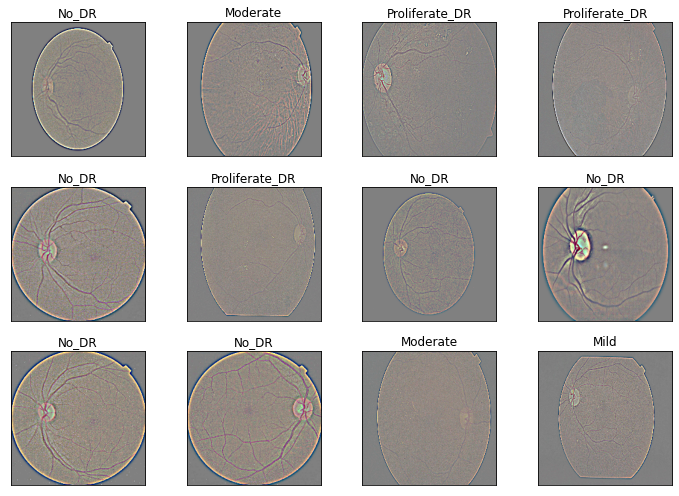

In [4]:
# Display some pictures of the dataset with their labels:

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

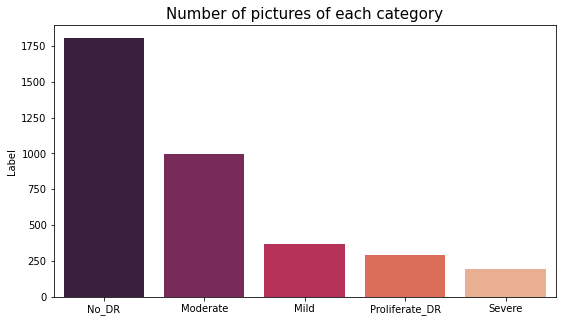

In [5]:
# Display the number of pictures of each category:

vc = image_df['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

In [6]:
def create_gen():
    # Load the Images with a generator and Data Augmentation:
    
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30, # Uncomment to use data augmentation
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30, # Uncomment to use data augmentation
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    
    return train_generator,test_generator,train_images,val_images,test_images

In [7]:
def get_model(model):
# Load the pretained model:

    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}
    
    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False
    
    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [8]:
# Separate in train and test data:
train_df, test_df = train_test_split(image_df, train_size=0.9, shuffle=True, random_state=1)

In [ ]:
# Dictionary with the models:
# models = {
#     "DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0},
#     "DenseNet169": {"model":tf.keras.applications.DenseNet169, "perf":0},
#     "InceptionResNetV2": {"model":tf.keras.applications.InceptionResNetV2, "perf":0},
#     "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
#     "MobileNet": {"model":tf.keras.applications.MobileNet, "perf":0},
#     "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
#     "ResNet101": {"model":tf.keras.applications.ResNet101, "perf":0},
#     "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
#     "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
#     "VGG19": {"model":tf.keras.applications.VGG19, "perf":0}
# }

# # Create the generators:
# train_generator,test_generator,train_images,val_images,test_images=create_gen()
# print('\n')

# # Fit the models:
# for name, model in models.items():
    
#     # Get the model:
#     m = get_model(model['model'])
#     models[name]['model'] = m
    
#     start = perf_counter()
    
#     # Fit the model:
#     history = m.fit(train_images,validation_data=val_images,epochs=1,verbose=1)
    
#     # Save the duration, the train_accuracy and the val_accuracy:
#     duration = perf_counter() - start
#     duration = round(duration,2)
#     models[name]['perf'] = duration
#     print(f"{name:20} trained in {duration} sec")
    
#     val_acc = history.history['val_accuracy']
#     models[name]['val_acc'] = [round(v,4) for v in val_acc]
    
#     train_acc = history.history['accuracy']
#     models[name]['train_accuracy'] = [round(v,4) for v in train_acc]

In [ ]:
# Create a DataFrame with the results
# models_result = []

# for name, v in models.items():
#     models_result.append([ name, 
#                           models[name]['train_accuracy'][-1],
#                           models[name]['val_acc'][-1], 
#                           models[name]['perf']])
    
# df_results = pd.DataFrame(models_result, 
#                           columns = ['model','train_accuracy','val_accuracy','Training time (sec)'])
# df_results.sort_values(by='val_accuracy', ascending=False, inplace=True)
# df_results.reset_index(inplace=True,drop=True)
# df_results

In [ ]:
# plt.figure(figsize = (15,5))
# sns.barplot(x = 'model', y = 'train_accuracy', data = df_results)
# plt.title('Accuracy on the Training Set (after 1 epoch)', fontsize = 15)
# plt.ylim(0,1)
# plt.xticks(rotation=90)
# plt.show()

# **Using a two-class model (DR and No_DR)!**

As we have seen before, the prediction are very accurate to predict if someone has Diabetic Retinopathy or not. Nevertheless, it is not good at predicting the intensity of Diabetic Retinopathy when it is present. Maybe because it is subjective to the doctor to rate the intensity degree and different doctors don't have the same way to evaluate them. Maybe there are other factors taken in consideration to evaluate the intensity, which are independent from the pictures. As this point, without knowing more about the data, we can only speculate.

So, we'll reduce the label to a two-class model, because we can imagine that the most important part of this analysis is to find out if someone has Diabetic Retinopathy or not.

In [9]:
# Map the labels to have only "No_DR" and "DR":

image_df_red = image_df.copy()
image_df_red['Label'] = image_df_red['Label'].apply(lambda x: x if x == 'No_DR' else 'DR')
image_df_red.head(5)

,Filepath,Label
0,../input/diabetic-retinopathy-224x224-gaussian...,No_DR
1,../input/diabetic-retinopathy-224x224-gaussian...,DR
2,../input/diabetic-retinopathy-224x224-gaussian...,DR
3,../input/diabetic-retinopathy-224x224-gaussian...,DR
4,../input/diabetic-retinopathy-224x224-gaussian...,No_DR


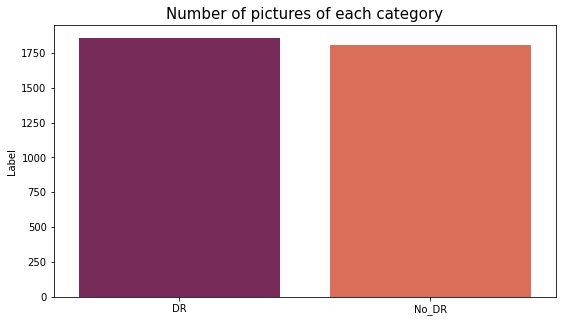

In [10]:
# Display the number of pictures of each category:

vc = image_df_red['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()


In [11]:
# Separate in train and test data:

train_df, test_df = train_test_split(image_df_red, train_size=0.9, shuffle=True, random_state=1)

In [12]:
# Create the generators:

train_generator,test_generator,train_images,val_images,test_images=create_gen()

# Load the pretained model:

pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False


inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(2, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy','AUC']
)

Found 2966 validated image filenames belonging to 2 classes.
Found 329 validated image filenames belonging to 2 classes.
Found 367 validated image filenames belonging to 2 classes.
9412608/9406464 [==============================] - 0s 0us/step


In [14]:
history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=50)

Epoch 1/50
93/93 [==============================] - 14s 150ms/step - loss: 0.1215 - accuracy: 0.9585 - auc: 0.9896 - val_loss: 0.0800 - val_accuracy: 0.9757 - val_auc: 0.9950
Epoch 2/50
93/93 [==============================] - 14s 152ms/step - loss: 0.1112 - accuracy: 0.9646 - auc: 0.9909 - val_loss: 0.1208 - val_accuracy: 0.9483 - val_auc: 0.9918
Epoch 3/50
93/93 [==============================] - 14s 153ms/step - loss: 0.0922 - accuracy: 0.9673 - auc: 0.9943 - val_loss: 0.0730 - val_accuracy: 0.9848 - val_auc: 0.9953
Epoch 4/50
93/93 [==============================] - 14s 148ms/step - loss: 0.0791 - accuracy: 0.9727 - auc: 0.9958 - val_loss: 0.0771 - val_accuracy: 0.9696 - val_auc: 0.9940
Epoch 5/50
93/93 [==============================] - 15s 158ms/step - loss: 0.0657 - accuracy: 0.9784 - auc: 0.9968 - val_loss: 0.0639 - val_accuracy: 0.9848 - val_auc: 0.9966
Epoch 6/50
93/93 [==============================] - 15s 157ms/step - loss: 0.0749 - accuracy: 0.9703 - auc: 0.9955 - val_loss

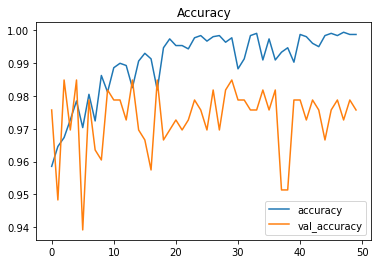

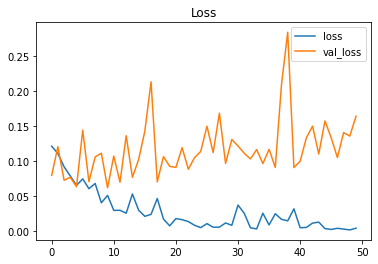

 ## Test Loss: 0.25072

## Accuracy on the test set: 96.73%

In [15]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

results = model.evaluate(test_images, verbose=0)

printmd(" ## Test Loss: {:.5f}".format(results[0]))
printmd("## Accuracy on the test set: {:.2f}%".format(results[1] * 100))
print('\n')



In [16]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

from sklearn.metrics import classification_report
y_test = list(test_df.Label)
from sklearn import metrics
print('Accuracy:', np.round(metrics.accuracy_score(y_test,pred),5))
print('Precision:', np.round(metrics.precision_score(y_test,pred, average='weighted'),5))
print('Recall:', np.round(metrics.recall_score(y_test,pred, average='weighted'),5))
print('F1 Score:', np.round(metrics.f1_score(y_test,pred, average='weighted'),5))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test,pred),5))
print(classification_report(y_test, pred))

Accuracy: 0.9673
Precision: 0.96739
Recall: 0.9673
F1 Score: 0.96732
Cohen Kappa Score: 0.93425
              precision    recall  f1-score   support

          DR       0.96      0.97      0.96       169
       No_DR       0.97      0.96      0.97       198

    accuracy                           0.97       367
   macro avg       0.97      0.97      0.97       367
weighted avg       0.97      0.97      0.97       367



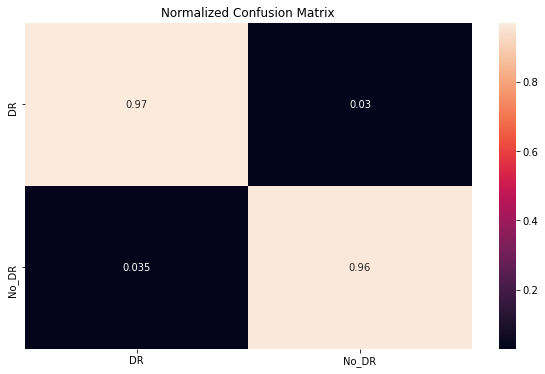

In [17]:
cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()